# Correlation & Regression in Python

> All these are based on lecture notes from Dannis L. Harmman (Washington Univ.)
> & Objective Analysis class organized by Jinho Yoon (GIST)

# Load Data

Here, we use Sea Surface Temperature (SST) monthly mean data
from https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html (ERSSTv5)

In [1]:
import math
import xarray as xr
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

path_sst = './data/sst.mnmean.nc'
file_sst = xr.open_dataset(path_sst)

print(file_sst)
sst = file_sst.sst

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 1999)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-07-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    geospatial_lon_min:        -1.0
    geospatial_lon_max:        359.0

# Calculate Nino34 (area-weighted average)

- The ordinary arithmetic average of all data points in the grid box (area average) is,
$$\bar{X'} = \frac{1}{M}\sum_{i=1}^M X_{i} $$
where, **M** is the number of grid points.


- However, the earth is not quadrilateral 2-dimension space, but a globular.
This means that grid box nearby the polar is narrower than the box close to Tropical area in geospatial data. 
Thus, when we calculate spatial area average with 2-D dataset, we should consider latitudinal weighting on each grid points.


- The spatial weighting is proportional to the cosine of the latitude, so the grid box average is calculated as, 
$$\bar{X'} = \frac{1}{\sum_{i}\sum_{j}cos(\varphi_{i,j})}\sum_{i}\sum_{j} X_{i,j}cos(\varphi_{i,j}) $$
where, **$\varphi$** represents degree of latitude and **i** is grid number for longitude and **j** is grid number for latitude.

In [2]:
# Xarray library supports function to calculate area-weighted average in a simple way.
# for more details, check out http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html

n34_area = sst.sel(lon=slice(190,240), lat=slice(5,-5))
weights = np.cos(np.deg2rad(n34_area.lat))
n34 = n34_area.weighted(weights)
n34 = n34.mean(('lon', 'lat'))

# Pearson Corrleation (2-D Map)

- Correlation is a statistical method to measure how strongly the pairs of data are related. It ranges from -1 to +1. The closer correlation value is to +1 or -1, the more closely the two are positively or negatively related. 


- The square of correlation value explain its relationship in a more quantitative way. It is equal to the percentage of the variation in one variable that is related to the variation in the other. For instance, correlation 0.5 indicates 25% of the variation is related.


- One thing should be causious is that correlation cannot explain casusal relationship.


- The pearson correlation is calculated as,
$$r_{x,y} = \frac{n\sum{x_iy_i}-\sum{x_i}\sum{y_i}}{\sqrt{n\sum{x_i}^2-(\sum{x_i})^2}\sqrt{n\sum{y_i}^2-(\sum{y_i})^2}} $$
where, **$r_{x,y}$** is pearson correlation and **n** is the number of observations.


- The t-value for the significance testing of pearson correlation is calculated as,
$$t = \frac{r_{x,y}\sqrt{n-2}}{\sqrt{1-r_{x,y}^2}} $$
where, **t** is t-value, **$r_{x,y}$** is perason correlation and **n** is the number of observations.


In [3]:
# Here, we calculate correlation and regression between nino34 and each grid point of SST from 1979 to 2019.
sst_ = sst.sel(time=slice('1979-01-01','2019-01-01'))
n34_ = n34.sel(time=slice('1979-01-01','2019-01-01'))

In [4]:
def covariance(x, y, dim=None):
    if x.shape != y.shape:
        x, y = xr.broadcast(x, y)
    return ((x - x.mean(dim=dim))*(y - y.mean(dim=dim))).mean(dim=dim)

def correlation(x, y, dim=None):
    corr= covariance(x, y, dim=dim) / (x.std(dim=dim) * y.std(dim=dim))
    t_val = corr*math.sqrt(len(x[dim])-2) / xr.ufuncs.sqrt(1-corr**2)
    return corr, t_val

In [5]:
corr_map, csig_map = correlation(sst_, n34_, dim='time')
print(corr_map.shape)

(89, 180)


/usr/local/python/2.7/envs/p3.6_cpu/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0.5, 1.0, 'Correlation Map')

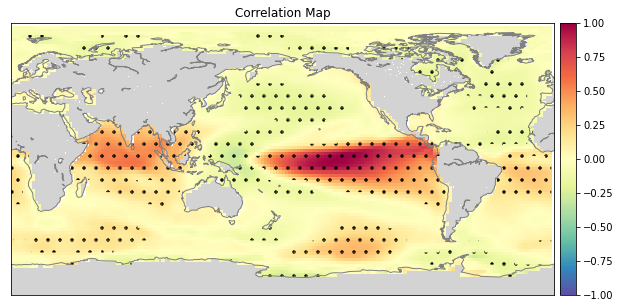

In [6]:
plt.figure(figsize=(12,5), frameon=False)

m = Basemap(lon_0=0, lat_0=0, 
            llcrnrlon=0., llcrnrlat=-90., urcrnrlon=360., urcrnrlat=90., 
            resolution='c')
m.drawcoastlines (linewidth=1.0, color='gray')
m.drawlsmask(land_color='lightgray') # landfill

x_, y_ = m(corr_map.lon, corr_map.lat)

corr_plot = m.pcolormesh(x_, y_, corr_map, cmap='Spectral_r', vmin=-1.0, vmax=1.0)
m.colorbar(corr_plot, location='right', pad='1%', size='3%')
    
#significance 99%
significance = ma.masked_less(abs(csig_map), 2.56)
plt.pcolor(x_, y_, significance, hatch='.', alpha=0.0)
plt.title('Correlation Map')

# Simple Regression (2-D Map)

- Regression is a statistical method to construct a linear model between two variables. 
$$\hat{y} = a + bx + \epsilon $$


- The coefficients a, b are calculated to minimize the least square error defined as,
$$Q = \frac{1}{N}\sum{(\hat{y}-y_i)^2}$$
where, **Q** is the least squaer error.


- The regression coefficient is calculated as,
$$b = \frac{\sum{(x_i-\bar{x})}\sum{(y_i-\bar{y})}}{\sum{(x-\bar{x_i})^2}} $$


- The linear regression model is based on several assumptions. 
    1. errors are normally distributed with zero mean and constant variance
    2. the estimated coefficients are equal to true values. (unbiased)
    3. the estimated model has the smallest variance between $\hat{y}$ and **y**. (efficient)
    4. the variance of the model approaches to zero as the size of sample increases. (consistent)


- To measure how much the linear regression model can explain data, the sums of squares terms are compared. **SST** is Sum of Squares Total, **SSR** is Sum of Squares Regression and **SSE** is Sum of Squares Error. 


<img src="./figure/regression.png" width="600" ><font size="2">https://www.slideserve.com/ellema/linear-regression-topics



- The square of correlation between variables is calculated as follows. This explains that if SSE is close to SST, which $R^2$ is close to 0, almost no variance is explained by the regression model.
$$R^2 = \frac{SSR}{SST} = 1-\frac{SSE}{SST} $$
 
    
- The significance of model is estimated with F-value and coefficient is with T-value.
$$F-value = \frac{MSR}{MSE} = \frac{\frac{SSR}{df_{MSR}}}{\frac{SSE}{df_{MSE}}},$$
$$T-value = \sqrt{F-value}$$
$$df_{MSR}=p,$$
$$df_{MSE}=n-p-1$$
    
where, **n** is number of observations and **p** is number of independent variables.


In [7]:
def covariance(x, y, dim=None):
    if x.shape != y.shape:
        x, y = xr.broadcast(x, y)
    return ((x - x.mean(dim=dim))*(y - y.mean(dim=dim))).mean(dim=dim)

def regression(x, y, dim=None):
    # x: 1-D index
    # y: 2-D spatial info
    
    coef_b = covariance(x, y, dim=dim) / x.var(dim=dim)
    coef_a = y.mean(dim=dim) - coef_b*x.mean(dim=dim)

    y_hat = coef_a + coef_b*x
    msr = ((y_hat - y_hat.mean(dim=dim))**2).sum(dim=dim)   
    mse = ((y_hat - y)**2).sum(dim=dim) / (len(y[dim])-2) # should be modified for the multiple independent variables
    f_var = msr/mse
    t_var = np.sqrt(f_var)

    return coef_b, t_var 

In [8]:
regr_map, rsig_map = regression(n34_, sst_, dim='time')

Text(0.5, 1.0, 'Regression Map')

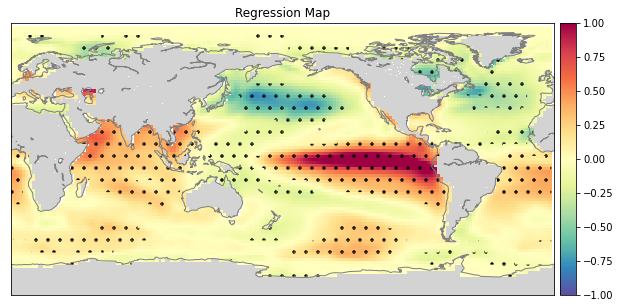

In [9]:
plt.figure(figsize=(12,5), frameon=False)

m = Basemap(lon_0=0, lat_0=0, 
            llcrnrlon=0., llcrnrlat=-90., urcrnrlon=360., urcrnrlat=90., 
            resolution='c')
m.drawcoastlines (linewidth=1.0, color='gray')
m.drawlsmask(land_color='lightgray') # landfill

x_, y_ = m(regr_map.lon, regr_map.lat)

corr_plot = m.pcolormesh(x_, y_, regr_map, cmap='Spectral_r', vmin=-1.0, vmax=1.0)
m.colorbar(corr_plot, location='right', pad='1%', size='3%')
    
#significance 99%
significance = ma.masked_less(abs(rsig_map), 2.56)
plt.pcolor(x_, y_, significance, hatch='.', alpha=0.0)
plt.title("Regression Map")